<a href="https://colab.research.google.com/github/NihalSidhu/Usage-vs-Points/blob/main/PlayerUsageVersusPointsScored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Player Usage Versus Point Scored


# Table of Contents
- Introduction to Player Usage
- What is Value Over Replacement (VOR)?
- The Big Question
- Data Collection & Processing
- Model Construction
- Visualizing the Data
- Analysis for Runningbacks
- Analysis for Wide Receivers and Tight Ends
- Conclusion

## Introduction to Player Usage

Throughout a fantasy football season, an owner has to make many different decisions to maximize his points in order to win his league. These decisions involve starting the correct players and benching the ones he/she expects to do poorly. An owner might have to add new players from the pool of undrafted players or look to trade players with another owner. These variety of decisions all seem very different, but they all boil down to one concept. Which player can we expect to perform better in the future? How can we determine a player's future outcome based on their current performance?

Luckily, there is a stat we can track in order to help determine a player's future fantasy performance. This stat is called usage.


*Usage* encompasses the number of times a player is involved during a game. Usage can include earning a target (a ball thrown your way) or completing a carry (a rushing attempt). A player's usage can often give us insight how much the player is being used in a NFL game and how many opportunities a game they receive to score fantasy points. With usage, we might be able to find how related it is with an actual player's fantasy score. In our case, usage only applies to positions that either receive or run the ball (runningbacks, wide receivers, and tight ends).

It makes sense that usage can relate to points scored, given that players need rush attempts and pass targets to score points. However, when it comes to usage, how useful is it when it comes to determining a player's fantasy output? That's what we will be diving into today.

## The Big Question

Today we are going to solve our question which is: **Can we use player's usage to determine a player's fantasy points? And how can we usage to make fantasy football decisions?** By understanding if this is true or not, we will be able to leverage a player's usage throughout a season to help make decisions on who to add, drop, trade and start. Let's dive into it.

## Data Collection & Processing

First we will be leveraging season long statistics from the 2022 season. We will read the 2022 fantasy stats file which encompasses each player's individual stats from the 2022 season, along with the fantasy points the yscored.

I was able to scrape the data from the FantasyPros.com site and save the data to csv. We can now use this data to find each player's usage in 2022.

In [1]:
# Importing useful libraries to help with analysis
import pandas as pd; pd.set_option('display.max_columns', None)
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('chained_assignment', None)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving FantasyStats2022.csv to FantasyStats2022.csv


Lets look at what the 2022 stats file provides us with.

In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['FantasyStats2022.csv']))
df.head()

,Rk,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,PassingTD,PassingAtt,PassingCmp,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,2PM,2PP,FantasyPoints
0,1,Patrick Mahomes*+,KAN,QB,27,17,17,1,1,5250,41,648,435,358,4,61,6,0,12,5,0,1.0,2.0,417.4
1,2,Josh Jacobs*+,LVR,RB,24,17,17,64,53,0,0,0,0,1653,12,340,400,0,0,3,1,NaN,NaN,328.3
2,3,Christian McCaffrey*,2TM,RB,26,17,16,108,85,34,1,1,1,1139,8,244,741,5,0,1,0,NaN,NaN,356.4
3,4,Derrick Henry *,TEN,RB,28,16,16,41,33,4,1,2,2,1538,13,349,398,0,0,6,3,NaN,NaN,302.8
4,5,Justin Jefferson*+,MIN,WR,23,17,17,184,128,34,0,2,2,24,1,4,1809,8,0,0,0,1.0,NaN,368.7


With the FantasyStats2022 file, I can look over each player's yard totals, along with key usage stats which include Tgt (targets) and RushingAtt (rushing attempts). It is important to note that the fantasy points are scored where a player gets 1 point per reception (PPR). This is important to account for when determining the usage for pass catching players (wide receivers and tight ends). I can now remove all QBs since we aren't aiming to determine their usage.

In [4]:
df = df[df.Pos != "QB"]

## Model Construction

Now we can find the usage per game for each player to help determine which players are being used the most often. Along with this, we are finding the fantasy points per game so that we can understand how usage correlates with the fantasy points scored per game. We will be calculating the usage for the positions separtely for wide receivers/tight ends versus runningbacks.

In [5]:
'''
Calculating the usage by adding up the targets and rushing attempts on
a per game basis. Calculating the fantasy points on per game basis.
'''

# Calculating usage and points for runningbacks
rb_df = df.loc[df['Pos'] == 'RB']
rb_df['Usage/Game'] = (rb_df['Tgt'] + df['RushingAtt'])/df['G']
rb_df['FantasyPoints/Game'] = rb_df['FantasyPoints'] / rb_df['G']

# Calculating usage and points for wide receivers and tight ends
pass_catchers = ['WR', 'TE']
pass_catchers_df = df.loc[df['Pos'].isin(pass_catchers)]
pass_catchers_df['Usage/Game'] = ((pass_catchers_df['Tgt']*2) +
                                  pass_catchers_df['RushingAtt'])/df['G']
pass_catchers_df['FantasyPoints/Game'] = pass_catchers_df['FantasyPoints'] / pass_catchers_df['G']

# Combining both dataframes back to one
players_df = pd.concat([rb_df, pass_catchers_df])
players_df = players_df[['Player', 'Pos', 'Usage/Game', 'FantasyPoints/Game']]
players_df.head()

,Player,Pos,Usage/Game,FantasyPoints/Game
1,Josh Jacobs*+,RB,23.764706,19.311765
2,Christian McCaffrey*,RB,20.705882,20.964706
3,Derrick Henry *,RB,24.375000,18.925000
5,Austin Ekeler,RB,19.470588,21.923529
9,Nick Chubb*,RB,19.941176,16.552941


We now have a table that includes each player's fantasy points per game along with their usage per game. Now we can start analyzing the usage and how it relates to points scored.

## Visualizing the Data

With the usage and fantasy points data, we can do some preliminary analysis on how usage is associated with actual fantasy points scored. Lets visualize some of this data by plotting the usage with the points scored.


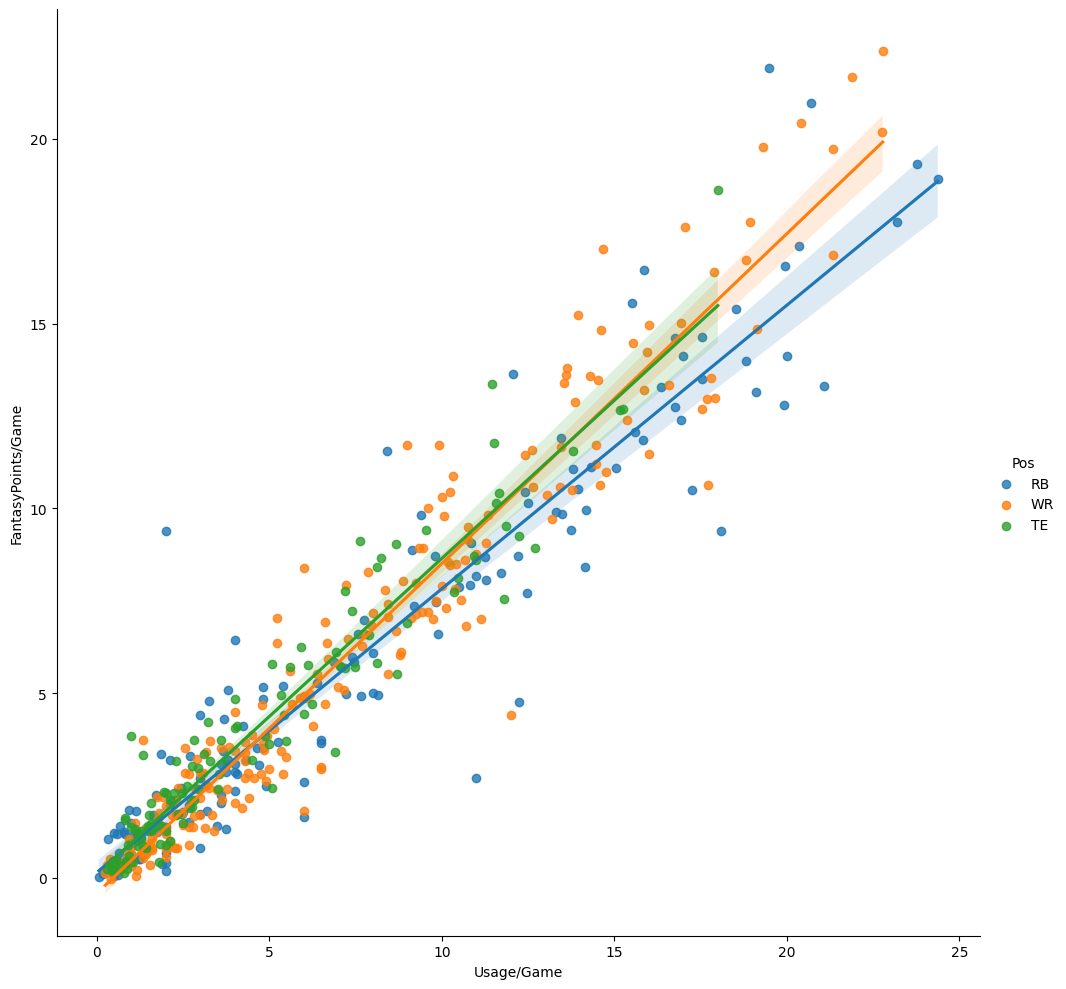

In [6]:
sns.lmplot(data=players_df, x='Usage/Game', y='FantasyPoints/Game', hue='Pos', height=10);

At first glance, we can see that for WRs and TEs (orange and green respectively), their lines of best fit are quite similar. It seems that both of their regression lines are similar given the fact that both positions are dependent on targets and rarely ever get rushing attempts.

Along with this, we can see that the regression lines seem to be aligned with what we said earlier. It seems that the fantasy points are increasing as the usage increases, which helps us understand how usage can relate to fantasy points scored.

## Analysis for Runningbacks

When diving into the RBs regression line, we see that it is a bit different and there there seems to be a couple outliers for the position. In order to better understand the runningbacks' relationship between usage and points scored, lets find if they are associated. One way to do this is to find how strong the correlation is between the usage and points scored.

In [7]:
# Using the rb_df from earlier
rb_df['Usage/Game'].corr(rb_df['FantasyPoints/Game'])


0.9485083956714522

By using the runningback dataframe from earlier, we can see that **there is a strong correlation (0.9485) between the usage and the fantasy points scored for RBs.** Although correlation doesn't always imply causation, we can begin to understand how greater usage can lead to more points scored. This correlation, paired with the graph, allows us to believe and make the assumption that as usage increases, so should a runningback's fantasy points. Similarly, we can assume the opposite that when a runningback's usage decreases, so should their fantasy points.




Now that we understand that runningbacks' usage can help determine their fantasy points, lets see which runningbacks overperformed or underperformed their usage in 2022. We can do this by finding the difference in actual points scored versus their usage.

In [13]:
# Creating column to calculate the difference in points and usage
rb_df['Diff Points v Usage'] = rb_df['FantasyPoints/Game'] - rb_df['Usage/Game']

# Removing irrelevant columns
rb_df = rb_df[['Player','Usage/Game','FantasyPoints/Game', 'Diff Points v Usage']]
rb_df = rb_df.head(80) # Limiting to only relevant top 80 runningbacks
rb_df.head(5)

,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
1,Josh Jacobs*+,23.764706,19.311765,-4.452941
2,Christian McCaffrey*,20.705882,20.964706,0.258824
3,Derrick Henry *,24.375000,18.925000,-5.450000
5,Austin Ekeler,19.470588,21.923529,2.452941
9,Nick Chubb*,19.941176,16.552941,-3.388235


At initial glance, we can see pretty glaring differences in points scored versus usage. We see that players like Josh Jacobs and Derrick Henry scored less points than their usage suggested. This could suggest that they undperformed, whereas a player like Austin Ekeler overperformed his usage. The "Diff Points v Usage" column will allow us to find which runningbacks overperformed their usage in 2022 and which ones underperformed. Let's take a look at the overperformers.

In [15]:
'''
Sorting by the players with highest differences. These are players that scored
more points than suggested, which paints them as over performers.
'''
rb_df.sort_values(by=['Diff Points v Usage'], ascending=False)[:15]


,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
77,Jerick McKinnon,8.411765,11.547059,3.135294
5,Austin Ekeler,19.470588,21.923529,2.452941
203,Dontrell Hilliard,4.000000,6.433333,2.433333
68,D'Andre Swift,12.071429,13.650000,1.578571
292,Marlon Mack,3.250000,4.787500,1.537500
273,Kyle Juszczyk*,1.875000,3.350000,1.475000
219,Nyheim Hines,3.812500,5.087500,1.275000
295,Ameer Abdullah,2.117647,3.182353,1.064706
279,Raheem Blackshear,2.692308,3.307692,0.615385
130,Breece Hall,15.857143,16.442857,0.585714


In the table above, we see players with positive differences and hence out performed their usage. This showcases that these players are scoring much more than their usage suggests, indicating they play well when they have the ball. Often times, when a player is playing well (outperforming their usage) they usually end up getting the ball more in the future. So in our case, with overperforming players, we can see that they are talented and could potentially receive a higher usage in the future, leading to more fantasy points. This table displays players we want to start and pickup throughout the fantasy season, given that they can score more than their expected usages. Some of the overperforming players that we might want to target in 2023 include Austin Ekeler, Tony Pollard and D'Andre Swift.


On the other hand, we can look at underperforming players as well. These are ones that are scoring less than expected.

In [16]:
'''
Sorting by the players with lowest differences. These are players that scored
less points than suggested, which paints them as under performers.
'''
rb_df.sort_values(by=['Diff Points v Usage'], ascending=True)[:20]

,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
124,Brian Robinson Jr.,18.083333,9.391667,-8.691667
107,Jonathan Taylor,21.090909,13.309091,-7.781818
99,Dameon Pierce,19.923077,12.800000,-7.123077
30,Najee Harris,19.117647,13.147059,-5.970588
53,Alvin Kamara,20.000000,14.113333,-5.886667
235,Zonovan Knight,14.142857,8.428571,-5.714286
3,Derrick Henry *,24.375000,18.925000,-5.450000
14,Saquon Barkley*,23.187500,17.750000,-5.437500
20,Dalvin Cook*,18.823529,13.988235,-4.835294
103,D'Onta Foreman,12.470588,7.705882,-4.764706


When looking at the underperforming tables, there are two ways to interpret it. One way to view it is looking at players that underperformed their usage, but had high usages. These players are getting the ball a lot, whether it be through rushing attempts or targets, and they have been recently underperforming. Given the team is giving them the ball often, it seems that they are talented and either had an unlucky season or are playing worse than they normally do. We can view these players as "bounce back candidates" where we believe that in 2023, they will have similar usage but will regress to their usage and begin to score as many points as their usage suggest. These bounce back players that we might want to target refer to Josh Jacobs, Saquon Barkley and Derrick Henry as they all have high usages, but under performed in 2022.

On the other hand, there are the players that had low usages and underperformed. These players are not trusted all that much from their respective teams given they don't get used all too often. On top of the limited usage, they have seemed to have played poorly in 2022. In this case, we believe that these players might have less usage in 2023 due to their poor previous performances and they may continue to underperform due to lack of talent. These underperforming, low usage runningbacks should be avoided. Some of these players include Zonovan Knight, D'Onta Foreman and AJ Dillon.

## Analysis for Wide Receivers and Tight Ends

Now that we were able to find a few players to target and avoid, lets do the same for the wide receivers and tight ends. With these 2 positions, we want to look into the same kinds of archetypes:
- Overperforming their usage: We want to TARGET these players given they are able to make the most out of each touch and can be thought of as talented.
- Underperforming, but with a high usage: We want to TARGET these players because although they underperformed, we are betting on them to bounceback and have point totals closer to their usage in 2023.
- Underperforming and with low usage: We want to AVOID these players because they don't get the ball often and they don't seem to do much with it either.

However, before exploring archetypes for wide receivers and tight ends, we want to first ensure that there is a high correlation between the usage and points scored for both positions. With a high correlation, we can then make the assumption that a higher usage can lead to higher points for both positions

Checking the correlation for wide receivers:

In [17]:
wr_df = players_df.loc[players_df['Pos'] == 'WR']
wr_df['Usage/Game'].corr(wr_df['FantasyPoints/Game'])

0.9665758654291158

**Above we can see that there is a high correlation (0.9665) for receivers and we can go ahead and assume that the higher the usage, the higher the points.** Lets check for tight ends now:

In [18]:
te_df = players_df.loc[players_df['Pos'] == 'TE']
te_df['Usage/Game'].corr(te_df['FantasyPoints/Game'])

0.9589383621166111

**Above we can see that there is a high correlation (0.9589) for tight ends as well, so we can contine forth with our assumption.** Lets dive into some of the overperforming and underperforming players for each position now.

Looking into overperforming wide receivers.


In [19]:
# Creating column to calculate the difference in points and usage
wr_df['Diff Points v Usage'] = wr_df['FantasyPoints/Game'] - wr_df['Usage/Game']

wr_df = wr_df[['Player','Usage/Game','FantasyPoints/Game', 'Diff Points v Usage']]
wr_df = wr_df.head(80) # Limiting to only relevant top 80 wide receivers

# Sorting by the players with highest differences.
wr_df.sort_values(by=['Diff Points v Usage'], ascending=False)[:15]

,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
171,Mecole Hardman,9.000000,11.725000,2.725000
164,Rashid Shaheed,6.000000,8.375000,2.375000
61,Christian Watson,9.928571,11.721429,1.792857
18,Jaylen Waddle,13.941176,15.247059,1.305882
166,DeVante Parker,7.230769,7.915385,0.684615
12,A.J. Brown*,17.058824,17.623529,0.564706
129,Jahan Dotson,10.333333,10.883333,0.550000
13,Stefon Diggs*,19.312500,19.787500,0.475000
152,Devin Duvernay*,7.857143,8.292857,0.435714
186,Isaiah Hodgins,9.600000,10.020000,0.420000


Per the table, some players we might want to target include Christian Watson, Jaylen Waddle and A.J. Brown.

Lets look at the underperforming WRs now.

In [20]:
wr_df.sort_values(by=['Diff Points v Usage'], ascending=True)[:20]

,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
132,Diontae Johnson,17.705882,10.629412,-7.076471
135,Marquise Brown,17.916667,13.000000,-4.916667
51,Garrett Wilson,17.529412,12.688235,-4.841176
114,Deebo Samuel,17.692308,12.953846,-4.738462
138,DeAndre Hopkins,21.333333,16.855556,-4.477778
67,Michael Pittman Jr.,17.812500,13.531250,-4.281250
64,Chris Godwin,19.133333,14.853333,-4.280000
194,Chase Claypool,11.133333,7.000000,-4.133333
133,Courtland Sutton,14.600000,10.626667,-3.973333
187,Robert Woods,10.705882,6.805882,-3.900000


Per the archetype, players who are underperforming with high usages are ones we want to target. Some of the players we might want to target are DeAndre Hopkins, Marquise Brown and Chris Godwin.

On the other hand, players who are underperforming with low usages are ones we want to avoid. These players to avoid include Michael Gallup, Robert Woods and Alec Pierce.

Finally, lets look into overperforming tight ends.

In [21]:
# Creating column to calculate the difference in points and usage
te_df['Diff Points v Usage'] = te_df['FantasyPoints/Game'] - te_df['Usage/Game']

te_df = te_df[['Player','Usage/Game','FantasyPoints/Game', 'Diff Points v Usage']]
te_df = te_df.head(80) # Limiting to only relevant top 80 runningbacks

# Sorting by the players with highest differences.
te_df.sort_values(by=['Diff Points v Usage'], ascending=False)[:15]

,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
22,George Kittle*,11.466667,13.366667,1.900000
24,Taysom Hill,7.625000,9.112500,1.487500
263,MyCole Pruitt,3.230769,4.230769,1.000000
238,Brock Wright,2.823529,3.741176,0.917647
294,Shane Zylstra,2.307692,3.153846,0.846154
350,Donald Parham,4.000000,4.833333,0.833333
363,Ross Dwelley,0.833333,1.625000,0.791667
331,Marcedes Lewis,0.823529,1.564706,0.741176
213,Will Dissly,5.066667,5.793333,0.726667
7,Travis Kelce*+,18.000000,18.605882,0.605882


Per the table, some players we might want to target include George Kittle, Travis Kelce and Cole Kmet.

Let's look at some of the underperforming tight ends now.

In [22]:
te_df.sort_values(by=['Diff Points v Usage'], ascending=True)[:15]

,Player,Usage/Game,FantasyPoints/Game,Diff Points v Usage
231,Kyle Pitts,11.800000,7.560000,-4.240000
150,Tyler Higbee,12.705882,8.941176,-3.764706
361,Cameron Brate,6.909091,3.400000,-3.509091
269,Logan Thomas,8.714286,5.521429,-3.192857
76,Pat Freiermuth,12.250000,9.262500,-2.987500
395,Brevin Jordan,5.090909,2.436364,-2.654545
156,Tyler Conklin,10.352941,7.735294,-2.617647
40,Mark Andrews*,15.266667,12.700000,-2.566667
28,T.J. Hockenson*,15.176471,12.670588,-2.505882
214,Greg Dulcich,11.000000,8.610000,-2.390000


As mentioned earlier with the archetypes, we want to target underperforming players with high usages. The tight ends we might want to target include Kyle Pitts, Mark Andrews and TJ Hockenson.

On the other hand, we want to avoid low usage underperformers and these players include Cameron Brate and Brevin Jordan.

## Conclusion

By completing this study, we were able to find players' usages and how it was associated with points. When looking back, we can see that there was a strong correlation between usage and points for each position. Let's see what the correlation was between the usage and points for all the players combined.

In [23]:
players_df['Usage/Game'].corr(players_df['FantasyPoints/Game'])


0.9568625896915606

As seen above, the correlation between the usage and fantasy points is 0.95, indicating a very strong correlation. As we mentioned earlier, a high correlation doesn't necessarily mean causation, but it does indicate an extremly strong relationship with two variables. In our case, the correlation can help answer our over arching question which was **Can we use player's usage to determine a player's fantasy points? And how can we usage to make fantasy football decisions?** With a high coefficient we were able to answer the first question as we were able to prove that we can use usage to help determine a player's fantasy points. Along with the correlation, the graph mapping of the usage versus point scored helped point to us that we can use usage to help find a player's fantasy points.

For the second question, we are now able to leverage usage to help project fantasy points scored. As seen in the previous analysis, we were able to leverage usage to identify 3 separate archetypes of players to target and avoid. These archetypes are summarized here:



Archetype 1 (Target): Players that overperform their usage
- RBs: Austin Ekeler, Tony Pollard and D'Andre Swift
- WRs: Christian Watson, Jaylen Waddle and Jahan Dotson
- TEs: George Kittle, Travis Kelce and Cole Kmet

Archetype 2 (Target): Players with high usage that underperformed
- RBs: Josh Jacobs, Saquon Barkley and Derrick Henry
- WRs: DeAndre Hopkins, Marquise Brown and DK Metcalf
- TEs: Kyle Pitts, Mark Andrews and TJ Hockenson

Archetype 3 (Avoid): Players with low usage that underperformed
- RBs: Zonovan Knight, D'Onta Foreman and AJ Dillon
- WRs: Michael Gallup, Robert Woods and Alec Pierce
- TEs: Cameron Brate and Brevin Jordan




It is important to note that there are many more factors that go into a player's point total rather than just usage. Whether a player is dealing with an injury, a new playbook or a new team, a player's total score can fluctuate quite a bit. Nonetheless, this study can help us follow a player's usage rather than just their points to help us determine future predictions of their outputs. I hope to see you look more into usage rather than just a player's fantasy points, as it can help you make decisions all throughout the 2023 fantasy season. Usage is king!